In [2]:
from torchvision.transforms import Resize, Compose, Grayscale
from datasets.pneumonia_dataset import PneumoniaDataset
import matplotlib.pyplot as plt
from models.cnns import ResNet, SmallCNN
from train_utils import train
import torch
from torch.utils.data import DataLoader, ConcatDataset, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import random
import warnings

warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [3]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


# Exploratory data analysis

### Loading data

In [ ]:
resize_transform = Resize((224,224)) # the images are large and have differing shapes
train_dataset_orig = PneumoniaDataset("data/chest_xray/train", resize_transform, use_rgb=False)
val_dataset_orig = PneumoniaDataset("data/chest_xray/val", resize_transform, use_rgb=False)

In [4]:
total_dataset = ConcatDataset([train_dataset_orig, val_dataset_orig])
train_idx, validation_idx = train_test_split(np.arange(len(total_dataset)),
                                             test_size=0.2,
                                             random_state=seed,
                                             shuffle=True,
                                             stratify=train_dataset_orig.labels+val_dataset_orig.labels)

train_dataset = Subset(total_dataset, train_idx)
val_dataset = Subset(total_dataset, validation_idx)

Due to the small size of the validation dataset, the estimates of the generalization performance we use when performing model selection would turn out inaccurate, therefore, we construct a different train/validation split. We combine the original train and validation datasets and then perform a stratified split with ratios 4:1. We perform a stratified split in order to retain class proportions present in the original dataset.

### Visualising image examples

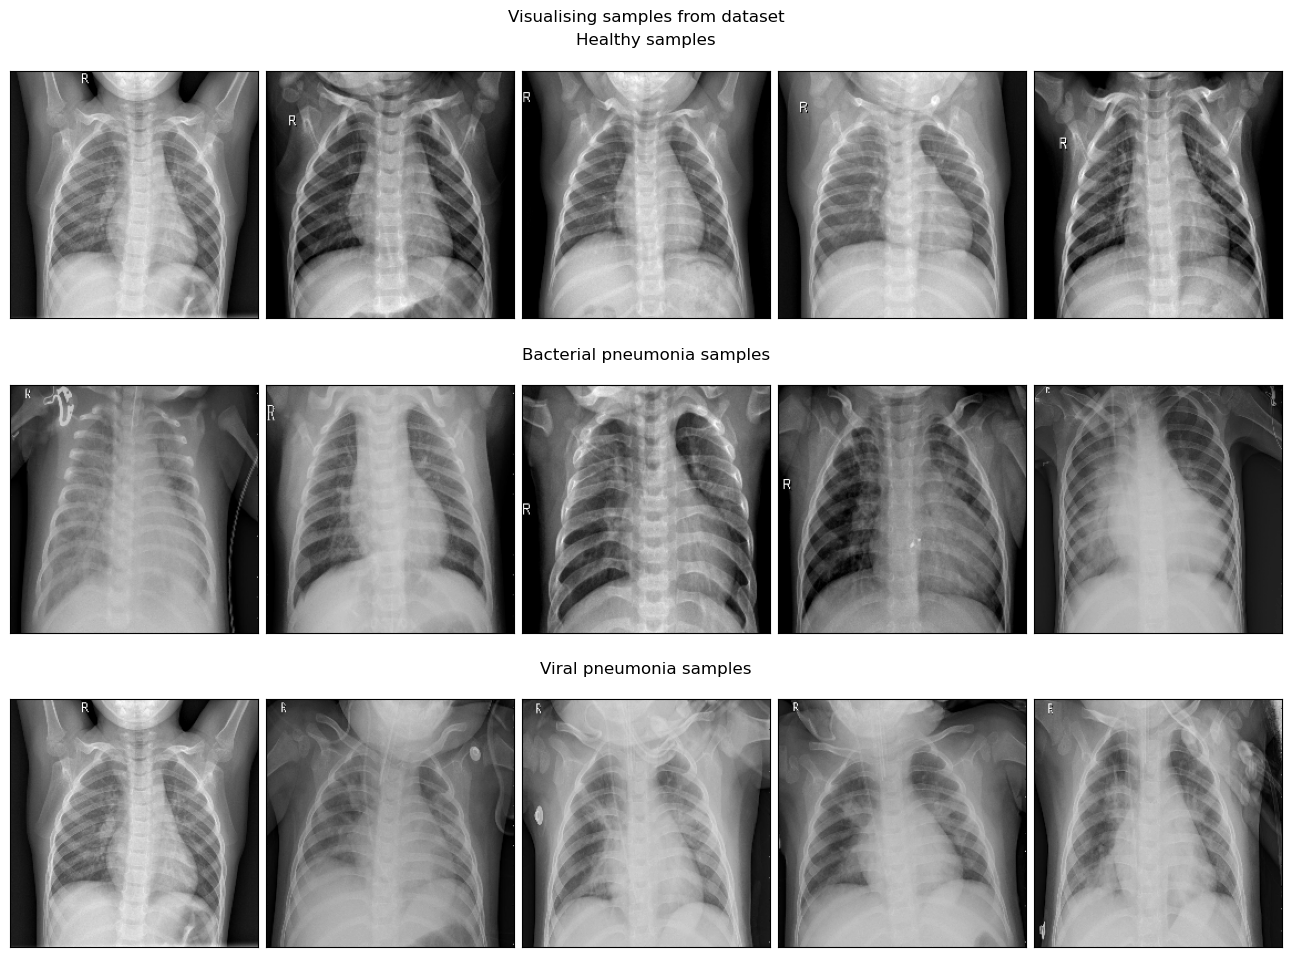

In [5]:
fig = plt.figure(constrained_layout=True, figsize=[12.8, 9.6])
fig.suptitle('Visualising samples from dataset')
subfigs = fig.subfigures(nrows=3, ncols=1)

subfigs[0].suptitle("Healthy samples")
axes = subfigs[0].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    ax.imshow(train_dataset_orig[i][0][0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

subfigs[1].suptitle("Bacterial pneumonia samples")
axes = subfigs[1].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    ax.imshow(train_dataset_orig[1341+i][0][0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

subfigs[2].suptitle("Viral pneumonia samples")
axes = subfigs[2].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    ax.imshow(train_dataset_orig[-i][0][0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

We can see some visual differences between healthy samples and samples with either type of pneumonia. We see that images of patients with pneumonia have regions which show up as dense in the images, whereas in healthy lungs, those areas are not dense. A difference between the images of lungs with viral and bacterial pneumonia is that in patients with bacterial pneumonia, the dense region is localised, whereas in images of lungs of people with viral pneumonia, the dense regions are present in multiple regions of the lungs.

In further analyses, we will not differentiate between different types of pneumonia.

### Visualising class counts

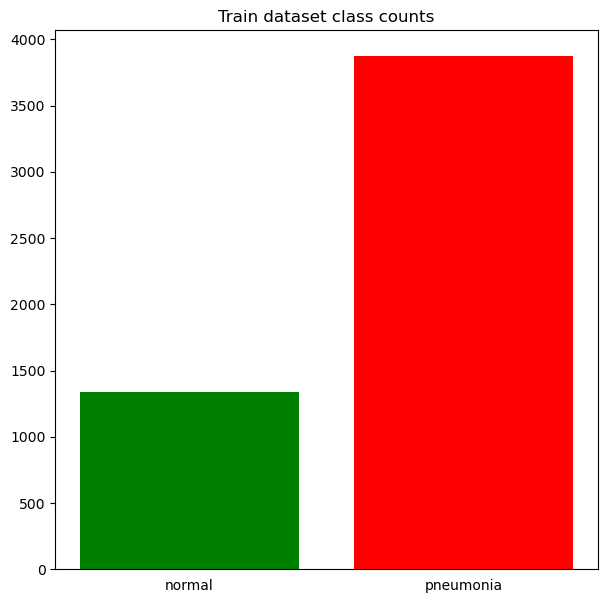

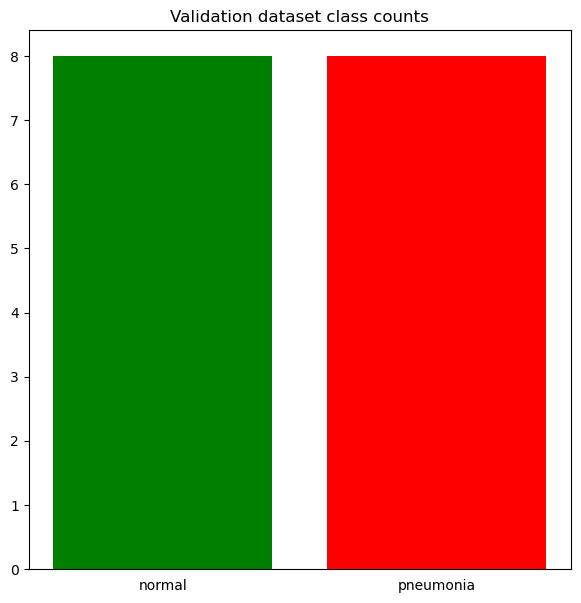

In [6]:
train_dataset_class_counts = [train_dataset_orig.labels.count(class_label) for class_label in range(2)]
val_dataset_class_counts = [val_dataset_orig.labels.count(class_label) for class_label in range(2)]

plt.figure(figsize = (7,7))
plt.bar(["normal", "pneumonia"], train_dataset_class_counts, color=['green', 'red'])
plt.tick_params(bottom = False)
plt.title("Train dataset class counts")
print()
plt.figure(figsize = (7,7))
plt.bar(["normal", "pneumonia"], val_dataset_class_counts, color=['green', 'red'])
plt.tick_params(bottom = False)
plt.title("Validation dataset class counts")
print()

As one can see, the dataset is highly imbalanced, in the sense that there are more x ray images displaying signs of pneumonia, than there are healthy ones. This is perhaps due to the fact that in pneumonia detection, false positives might have less detrimental effects than false negatives. Since there is nevertheless a sufficient number of examples of normal lungs present, we do not try to explore options to address the class imbalance.

### Preprocessing
Preprocessing is done in the `PneumoniaDataset` class. Namely the preprocessing consists of reshaping the images so that all of them have the same size and shape. Namely, we decided to resize the images to size (224,224). Also, the luminosity values of the image are rescaled to the range [0,1] in order for the model to be able to learn more easily. Some images in the dataset are RGB images, whereas others are grayscale (single-channel) images. We decided to convert all images to grayscale.

# Model
As our cnn model for creating prediction, we use a simple model with 4 convolutional and 3 fully-connected layers. We also experimented with the smallest pre-trained resnet, but the model had too much capacity for the task at hand so we settled on the small model we defined ourselves. A detailed sketch of the model architecture is given in the accompanying report.

We decided to frame this problem as a 2-class classification problem. Therefore, our neural network outputs a single number in the range [0,1] where 0 corresponds to a healthy sample and 1 corresponds to pneumonia

In [7]:
model = SmallCNN()

### Training

We chose to train our model using the Adam optimizer. The loss function we used was binary cross-entropy loss. We chose not to use a learning rate scheduler, as the optimizer is adaptive and therefore not particularly sensitive to choice of learning rate. The batch size we used was 256. After each training epoch, we evaluate the performance of our model on the validation set. The metrics we use to measure the performance of our model are area under the ROC-curve, accuracy, precision, recall and F1 score. We trained our model for 30 epochs and after each epoch saved the model in case it was performing better than the previous best-performing model. As the final model, we choose the model that achieved the lowest binary cross-entropy loss on the validation dataset. As a tie-breaker metric in case of multiple models with the same loss, we use the area under the ROC-curve.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_args = {
    "epochs": 30, 
    "device": device,
    "scheduler": "",
    "optimizer_args": { "lr": 0.0001},
    "verbose": True,
    "batch_size": 256
}

In [9]:
trainloader = DataLoader(train_dataset, train_args["batch_size"], shuffle=True)
valloader = DataLoader(val_dataset, train_args["batch_size"], shuffle=False)

In [10]:
torch.cuda.empty_cache()

In [11]:
results = train(model, trainloader, valloader, train_args)
model = results["model"]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0 | 	 train loss:  0.0028, train roc auc: 0.5000, train accuracy: 0.7422, train precision: 0.7422, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0031, val roc auc: 0.5000, val accuracy: 0.7421, val precision: 0.7421, val recall: 1.0000, val f1 score: 0.8520 


  3%|▎         | 1/30 [00:04<01:56,  4.00s/it]

Epoch 1 | 	 train loss:  0.0025, train roc auc: 0.5000, train accuracy: 0.7422, train precision: 0.7422, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0028, val roc auc: 0.5000, val accuracy: 0.7421, val precision: 0.7421, val recall: 1.0000, val f1 score: 0.8520 


  7%|▋         | 2/30 [00:06<01:29,  3.19s/it]

Epoch 2 | 	 train loss:  0.0024, train roc auc: 0.5000, train accuracy: 0.7422, train precision: 0.7422, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0028, val roc auc: 0.5000, val accuracy: 0.7421, val precision: 0.7421, val recall: 1.0000, val f1 score: 0.8520 


 10%|█         | 3/30 [00:09<01:19,  2.93s/it]

Epoch 3 | 	 train loss:  0.0024, train roc auc: 0.5000, train accuracy: 0.7422, train precision: 0.7422, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0028, val roc auc: 0.5000, val accuracy: 0.7421, val precision: 0.7421, val recall: 1.0000, val f1 score: 0.8520 


 13%|█▎        | 4/30 [00:11<01:12,  2.79s/it]

Epoch 4 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7422, train precision: 0.7422, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0027, val roc auc: 0.5000, val accuracy: 0.7421, val precision: 0.7421, val recall: 1.0000, val f1 score: 0.8520 


 17%|█▋        | 5/30 [00:14<01:08,  2.74s/it]

Epoch 5 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7422, train precision: 0.7422, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0027, val roc auc: 0.5000, val accuracy: 0.7421, val precision: 0.7421, val recall: 1.0000, val f1 score: 0.8520 


 20%|██        | 6/30 [00:17<01:04,  2.68s/it]

Epoch 6 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7422, train precision: 0.7422, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0027, val roc auc: 0.5000, val accuracy: 0.7421, val precision: 0.7421, val recall: 1.0000, val f1 score: 0.8520 


 23%|██▎       | 7/30 [00:19<01:00,  2.64s/it]

Epoch 7 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7422, train precision: 0.7422, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0027, val roc auc: 0.5000, val accuracy: 0.7421, val precision: 0.7421, val recall: 1.0000, val f1 score: 0.8520 


 27%|██▋       | 8/30 [00:22<00:57,  2.64s/it]

Epoch 8 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7422, train precision: 0.7422, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0026, val roc auc: 0.5000, val accuracy: 0.7421, val precision: 0.7421, val recall: 1.0000, val f1 score: 0.8520 


 30%|███       | 9/30 [00:24<00:54,  2.61s/it]

Epoch 9 | 	 train loss:  0.0022, train roc auc: 0.5000, train accuracy: 0.7422, train precision: 0.7422, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0026, val roc auc: 0.5000, val accuracy: 0.7421, val precision: 0.7421, val recall: 1.0000, val f1 score: 0.8520 


 33%|███▎      | 10/30 [00:27<00:52,  2.60s/it]

Epoch 10 | 	 train loss:  0.0022, train roc auc: 0.5000, train accuracy: 0.7422, train precision: 0.7422, train recall: 1.0000, train f1 score: 0.8520 |               
	 val loss: 0.0024, val roc auc: 0.5000, val accuracy: 0.7421, val precision: 0.7421, val recall: 1.0000, val f1 score: 0.8520 


 37%|███▋      | 11/30 [00:30<00:49,  2.63s/it]

Epoch 11 | 	 train loss:  0.0020, train roc auc: 0.5108, train accuracy: 0.7470, train precision: 0.7463, train recall: 0.9984, train f1 score: 0.8542 |               
	 val loss: 0.0022, val roc auc: 0.5535, val accuracy: 0.7641, val precision: 0.7634, val recall: 0.9884, val f1 score: 0.8615 


 40%|████      | 12/30 [00:32<00:47,  2.63s/it]

Epoch 12 | 	 train loss:  0.0018, train roc auc: 0.6550, train accuracy: 0.8017, train precision: 0.8097, train recall: 0.9578, train f1 score: 0.8776 |               
	 val loss: 0.0021, val roc auc: 0.5824, val accuracy: 0.7765, val precision: 0.7756, val recall: 0.9833, val f1 score: 0.8672 


 43%|████▎     | 13/30 [00:35<00:44,  2.63s/it]

Epoch 13 | 	 train loss:  0.0016, train roc auc: 0.7334, train accuracy: 0.8394, train precision: 0.8495, train recall: 0.9524, train f1 score: 0.8980 |               
	 val loss: 0.0016, val roc auc: 0.7400, val accuracy: 0.8472, val precision: 0.8518, val recall: 0.9614, val f1 score: 0.9033 


 47%|████▋     | 14/30 [00:37<00:42,  2.64s/it]

Epoch 14 | 	 train loss:  0.0013, train roc auc: 0.7932, train accuracy: 0.8681, train precision: 0.8830, train recall: 0.9478, train f1 score: 0.9143 |               
	 val loss: 0.0016, val roc auc: 0.7027, val accuracy: 0.8367, val precision: 0.8308, val recall: 0.9794, val f1 score: 0.8990 


 50%|█████     | 15/30 [00:40<00:39,  2.63s/it]

Epoch 15 | 	 train loss:  0.0012, train roc auc: 0.8152, train accuracy: 0.8743, train precision: 0.8979, train recall: 0.9372, train f1 score: 0.9171 |               
	 val loss: 0.0013, val roc auc: 0.8162, val accuracy: 0.8797, val precision: 0.8965, val recall: 0.9472, val f1 score: 0.9212 


 53%|█████▎    | 16/30 [00:43<00:36,  2.63s/it]

Epoch 16 | 	 train loss:  0.0011, train roc auc: 0.8447, train accuracy: 0.8925, train precision: 0.9145, train recall: 0.9433, train f1 score: 0.9287 |               
	 val loss: 0.0012, val roc auc: 0.8293, val accuracy: 0.8902, val precision: 0.9027, val recall: 0.9550, val f1 score: 0.9281 


 57%|█████▋    | 17/30 [00:45<00:34,  2.63s/it]

Epoch 17 | 	 train loss:  0.0009, train roc auc: 0.8570, train accuracy: 0.9008, train precision: 0.9211, train recall: 0.9475, train f1 score: 0.9341 |               
	 val loss: 0.0011, val roc auc: 0.8839, val accuracy: 0.9102, val precision: 0.9406, val recall: 0.9382, val f1 score: 0.9394 


 60%|██████    | 18/30 [00:48<00:31,  2.61s/it]

Epoch 18 | 	 train loss:  0.0009, train roc auc: 0.8661, train accuracy: 0.9063, train precision: 0.9265, train recall: 0.9491, train f1 score: 0.9377 |               
	 val loss: 0.0010, val roc auc: 0.8761, val accuracy: 0.9112, val precision: 0.9329, val recall: 0.9485, val f1 score: 0.9407 


 63%|██████▎   | 19/30 [00:51<00:28,  2.63s/it]

Epoch 19 | 	 train loss:  0.0009, train roc auc: 0.8735, train accuracy: 0.9097, train precision: 0.9314, train recall: 0.9482, train f1 score: 0.9397 |               
	 val loss: 0.0010, val roc auc: 0.8560, val accuracy: 0.9064, val precision: 0.9176, val recall: 0.9601, val f1 score: 0.9384 


 67%|██████▋   | 20/30 [00:53<00:26,  2.63s/it]

Epoch 20 | 	 train loss:  0.0009, train roc auc: 0.8737, train accuracy: 0.9099, train precision: 0.9314, train recall: 0.9485, train f1 score: 0.9399 |               
	 val loss: 0.0011, val roc auc: 0.9244, val accuracy: 0.9236, val precision: 0.9729, val recall: 0.9228, val f1 score: 0.9472 


 70%|███████   | 21/30 [00:56<00:23,  2.62s/it]

Epoch 21 | 	 train loss:  0.0008, train roc auc: 0.8839, train accuracy: 0.9183, train precision: 0.9362, train recall: 0.9549, train f1 score: 0.9455 |               
	 val loss: 0.0011, val roc auc: 0.9266, val accuracy: 0.9198, val precision: 0.9779, val recall: 0.9125, val f1 score: 0.9441 


 73%|███████▎  | 22/30 [00:58<00:20,  2.62s/it]

Epoch 22 | 	 train loss:  0.0007, train roc auc: 0.8965, train accuracy: 0.9235, train precision: 0.9450, train recall: 0.9524, train f1 score: 0.9487 |               
	 val loss: 0.0009, val roc auc: 0.8763, val accuracy: 0.9169, val precision: 0.9302, val recall: 0.9601, val f1 score: 0.9449 


 77%|███████▋  | 23/30 [01:01<00:18,  2.62s/it]

Epoch 23 | 	 train loss:  0.0007, train roc auc: 0.8927, train accuracy: 0.9233, train precision: 0.9416, train recall: 0.9559, train f1 score: 0.9487 |               
	 val loss: 0.0009, val roc auc: 0.8875, val accuracy: 0.9226, val precision: 0.9372, val recall: 0.9601, val f1 score: 0.9485 


 80%|████████  | 24/30 [01:04<00:15,  2.62s/it]

Epoch 24 | 	 train loss:  0.0007, train roc auc: 0.8969, train accuracy: 0.9274, train precision: 0.9434, train recall: 0.9598, train f1 score: 0.9515 |               
	 val loss: 0.0009, val roc auc: 0.9264, val accuracy: 0.9284, val precision: 0.9718, val recall: 0.9305, val f1 score: 0.9507 


 83%|████████▎ | 25/30 [01:06<00:13,  2.64s/it]

Epoch 25 | 	 train loss:  0.0007, train roc auc: 0.9041, train accuracy: 0.9295, train precision: 0.9489, train recall: 0.9565, train f1 score: 0.9527 |               
	 val loss: 0.0010, val roc auc: 0.9354, val accuracy: 0.9274, val precision: 0.9821, val recall: 0.9189, val f1 score: 0.9495 


 87%|████████▋ | 26/30 [01:09<00:10,  2.63s/it]

Epoch 26 | 	 train loss:  0.0007, train roc auc: 0.9114, train accuracy: 0.9341, train precision: 0.9532, train recall: 0.9581, train f1 score: 0.9557 |               
	 val loss: 0.0009, val roc auc: 0.9338, val accuracy: 0.9341, val precision: 0.9758, val recall: 0.9344, val f1 score: 0.9546 


 90%|█████████ | 27/30 [01:12<00:07,  2.62s/it]

Epoch 27 | 	 train loss:  0.0006, train roc auc: 0.9117, train accuracy: 0.9362, train precision: 0.9522, train recall: 0.9623, train f1 score: 0.9572 |               
	 val loss: 0.0009, val roc auc: 0.9363, val accuracy: 0.9341, val precision: 0.9784, val recall: 0.9318, val f1 score: 0.9545 


 93%|█████████▎| 28/30 [01:14<00:05,  2.63s/it]

Epoch 28 | 	 train loss:  0.0006, train roc auc: 0.9152, train accuracy: 0.9379, train precision: 0.9546, train recall: 0.9620, train f1 score: 0.9583 |               
	 val loss: 0.0012, val roc auc: 0.9444, val accuracy: 0.9265, val precision: 0.9930, val recall: 0.9073, val f1 score: 0.9482 


 97%|█████████▋| 29/30 [01:17<00:02,  2.63s/it]

Epoch 29 | 	 train loss:  0.0007, train roc auc: 0.9166, train accuracy: 0.9355, train precision: 0.9574, train recall: 0.9556, train f1 score: 0.9565 |               
	 val loss: 0.0009, val roc auc: 0.9394, val accuracy: 0.9370, val precision: 0.9798, val recall: 0.9344, val f1 score: 0.9565 


100%|██████████| 30/30 [01:19<00:00,  2.67s/it]

Best model 29 tensor(0.0009, device='cuda:0') 0.9394036894036893


### Evaluation on test dataset

In [12]:
from train_utils import validate
test_dataset = PneumoniaDataset("data/chest_xray/test", resize_transform, use_rgb=False)
testloader = DataLoader(test_dataset, batch_size=train_args["batch_size"], shuffle=False)

/home/lrabuzin/.conda/envs/ML4HC/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [36]:
test_stats = validate(results["model"], testloader, train_args)
print(f"Test results -> \narea under the ROC-curve: {test_stats[1]:.3f},\naccuracy: {test_stats[2]:.3f},\nprecision: {test_stats[3]:.3f},\nrecall:{test_stats[4]:.3f},\nf1: {test_stats[5]:.3f}")

Test results -> 
area under the ROC-curve: 0.768,
accuracy: 0.817,
precision: 0.790,
recall:0.964,
f1: 0.868


# Integrated gradients

Integrated gradients is a method of attributing the prediction of a deep network to its input features, as an attempt towards explaining individual predictions. As a baseline, we use the zero-image (i.e. all-black image), since it represents the absence of signal. In the visualizations that we rendered, the regions highlighted green correspond to positive attributions (i.e. these regions contribute to the model predicting that a person has pneumonia), while the red regions correspond to negative attributions (i.e. these regions contribute to the model predicting that a person is healthy).

In [14]:
def integrated_gradients(model, input, n_iter):
    """
    Expects batched input a.k.a. input of shape (1, 1, H, W)
    """
    model.cpu()
    model.eval()
    baseline = torch.zeros(input.shape)
    input = input.requires_grad_()
    gradient_sum = torch.zeros(input.shape)
    for k in range(1, n_iter+1):
        model.zero_grad()
        kth_path_image = baseline + k/n_iter * (input - baseline)
        output = model(kth_path_image)
        gradients = torch.autograd.grad(outputs=output, inputs=input, retain_graph=True)[0]
        gradient_sum += gradients
    return (input - baseline) * gradient_sum * (1/n_iter)

In [15]:
def visualise_attribution_map(attribution, input, attribution_mul = 0.7, input_mul = 0.3):

    root_img = input[0].detach().permute([1,2,0]).numpy()

    ig = attribution[0]
    green_mask = ig > 0
    red_mask = ig < 0
    green = torch.clone(ig).detach()
    red = torch.clone(ig).detach()
    green[red_mask] = 0
    red[green_mask] = 0

    green = green[0]
    red = red[0]

    red = torch.abs(red)

    max_val = max(green.max(), red.max())

    green = green/max_val
    red = red/max_val
    blue = torch.zeros(red.shape)

    color_mask = torch.stack([red, green, blue])

    return attribution_mul*color_mask.permute([1,2,0]).numpy() + input_mul*root_img


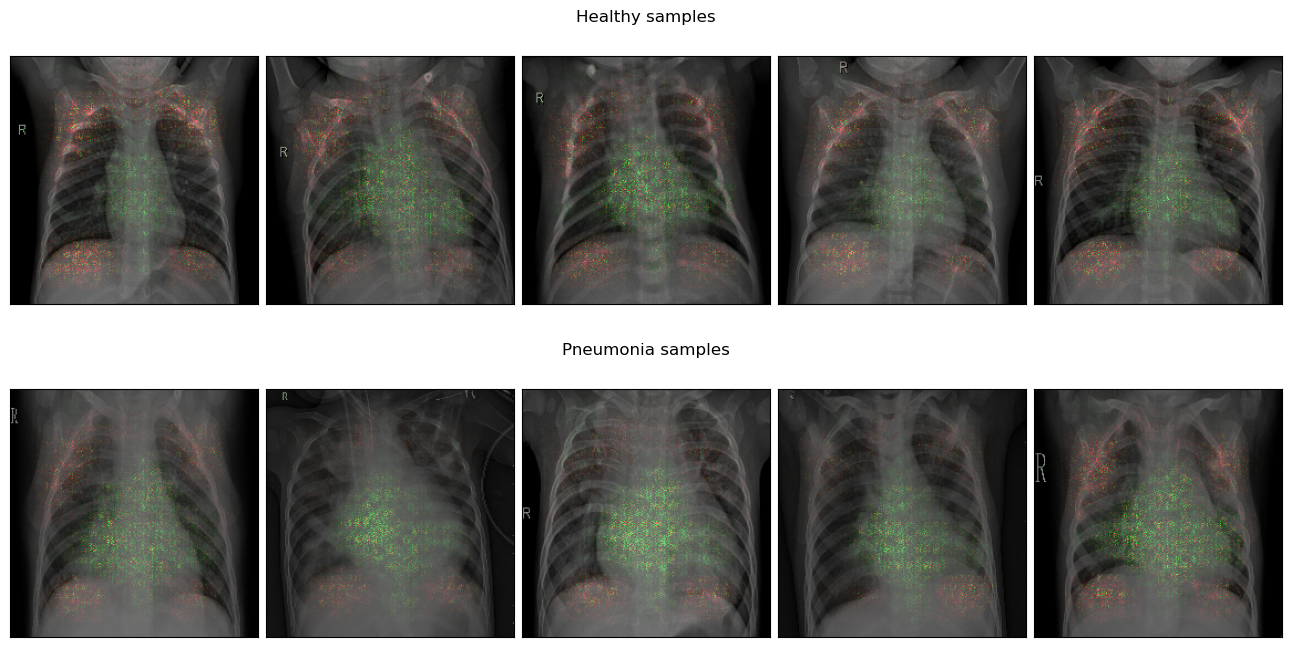

In [40]:
%%capture --no-display

fig = plt.figure(constrained_layout=True, figsize=[12.8, 6.6])
# fig.suptitle('Explaining outputs of model with integrated gradients')
subfigs = fig.subfigures(nrows=2, ncols=1)

offset = 20

subfigs[0].suptitle("Healthy samples")
axes = subfigs[0].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[i+offset][0].unsqueeze(0).requires_grad_(True)
    attribution = integrated_gradients(model, input, 500)
    ax.imshow(visualise_attribution_map(attribution, input, 1, 0.5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

subfigs[1].suptitle("Pneumonia samples")
axes = subfigs[1].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[-(i+offset+1)][0].unsqueeze(0).requires_grad_(True)
    attribution = integrated_gradients(model, input, 500)
    ax.imshow(visualise_attribution_map(attribution, input, 1, 0.5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


We can see that there are clear visual differences between the attribution maps of healthy and diseased samples. In all samples, the middle region of the image is deemed as contributing to a positive pneumonia prediction. However, the positive signals are much larger and higher-intensity in the case of the model predicting that an image corresponds to a person with pneumonia. Furthermore, the areas highlighted green in the photos with pneumonia are the areas which exhibit an abnormal density in the scan, compared to the healthy samples. Curiously, in both the healthy and unhealthy samples, the model seems to identify negative signal in the upper and lower corners of the images, which doesn't seem to match our biological intuition of how the model is supposed to make predictions.

# Grad-cam

Grad-CAM uses the gradient information flowing into the last convolutional layer of the CNN to assign importance values to each neuron for a particular decision of interest. In our case, we visualise the gradient information flowing into the last convolutional layer of our CNN with respect to predicting that the image corresponds to pneumonia.

In [17]:
from matplotlib import cm
import numpy as np
from skimage.transform import resize
def gradCam(model, input):
    """
    Expects batched input a.k.a. input of shape (1, 1, H, W)
    """
    model.cpu()
    model.eval()
    model.zero_grad()
    input = input.requires_grad_()

    output = model(input)
    grad = torch.autograd.grad(outputs=output, inputs=model.last_conv, retain_graph=True)[0]
    pooled_grad = torch.mean(grad, dim=[0, 2, 3])
    activations = torch.clone(model.last_conv)
    for i in range(pooled_grad.shape[0]):
        activations[:, i, :, :] *= pooled_grad[i]
    attributions = torch.mean(activations, dim=1).squeeze()
    attributions = torch.nn.functional.relu(attributions)
    return attributions

In [18]:
def visualise_gradCam(attributions, input):
    normalised_attributions = (attributions/(torch.max(attributions)+1e-30)).detach().numpy()
    attribution_colors_ = cm.magma(normalised_attributions)
    attribution_colors = resize(attribution_colors_, (224,224), order=0)
    input_colors = cm.gray(input[0][0].detach().numpy())
    return 0.4*attribution_colors + 0.6*input_colors

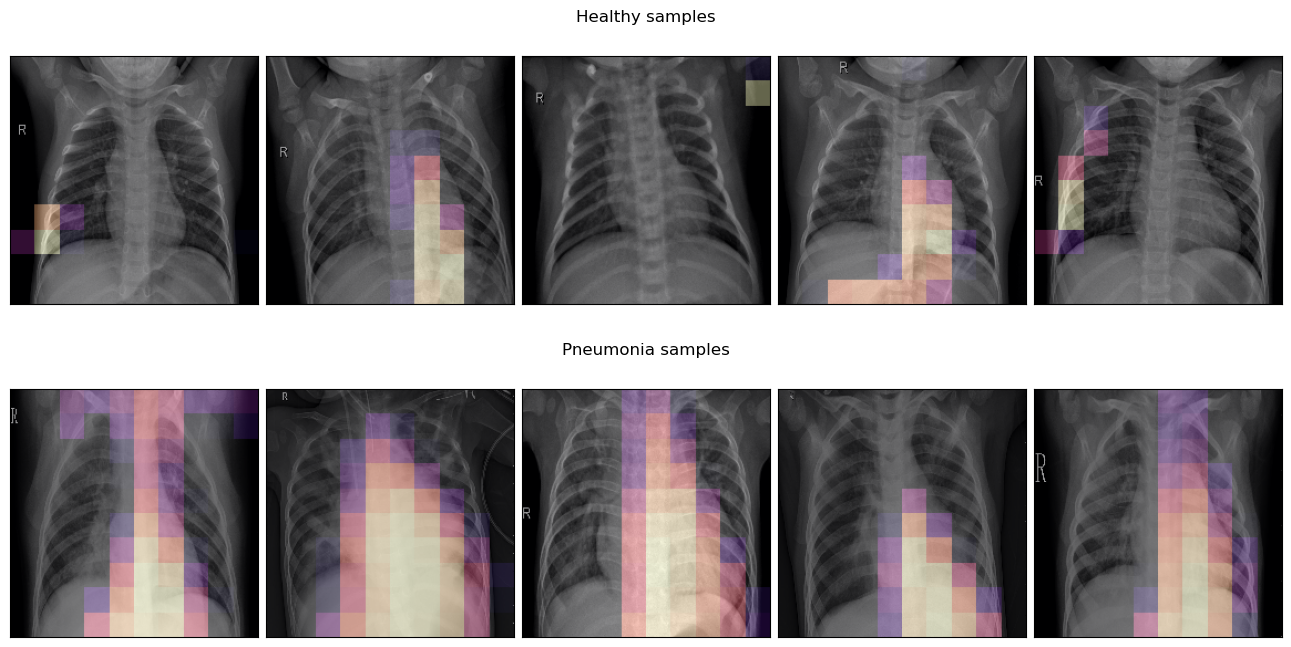

In [19]:
%%capture --no-display

fig = plt.figure(constrained_layout=True, figsize=[12.8, 6.6])
# fig.suptitle('Explaining outputs of model with GradCAM')
subfigs = fig.subfigures(nrows=2, ncols=1)

offset = 20

subfigs[0].suptitle("Healthy samples")
axes = subfigs[0].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[i+offset][0].unsqueeze(0).requires_grad_(True)
    attribution = gradCam(model, input)
    ax.imshow(visualise_gradCam(attribution, input))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

subfigs[1].suptitle("Pneumonia samples")
axes = subfigs[1].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[-(i+offset+1)][0].unsqueeze(0).requires_grad_(True)
    attribution = gradCam(model, input)
    ax.imshow(visualise_gradCam(attribution, input))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Since we predict the gradient information flowing into the last convolutional layer, the GradCAM attribution maps we get are very coarse (10x10). We upscale the attribution maps we get with GradCAM and overla them over the input images. A clear trend that emerges here is that the support for pneumonia in attribution maps of healthy images is almost non-existent. For images wih pneumonia on the other hand, the support for pneumonia in the attribution maps is both very large and very intense. The regions the model focuses on also seem to match our biological intuition. The model seems to focus on regions with increased density in the scan. Attributions seem to be consistent across samples.

Compared to Integrated gradients, GradCam can't highlight negative contributions, but seems to show a much clearer trend when differentiating between healthy and unhealthy samples. Both methods seem to highlight sensible regions. GradCAM also offers more coarse attribution maps, but both methods seem to mostly agree on which regions of the image are responsible for the model predicting pneumonia.

# Data Randomization Test

In [20]:
from random import shuffle

In [32]:
permuted_model = SmallCNN()

In [22]:
permuted_train_ds = PneumoniaDataset("data/chest_xray/train", resize_transform, use_rgb=False)
permuted_val_ds = PneumoniaDataset("data/chest_xray/val", resize_transform, use_rgb=False)
permuted_test_ds = PneumoniaDataset("data/chest_xray/test", resize_transform, use_rgb=False)

shuffle(permuted_train_ds.labels)
shuffle(permuted_val_ds.labels)
shuffle(permuted_test_ds.labels)

/home/lrabuzin/.conda/envs/ML4HC/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
permuted_train_args = {
    "epochs": 100, 
    "device": device,
    "scheduler": "CosineAnnealingLR",
    "optimizer_args": { "lr": 0.001},
    "verbose": True,
    "batch_size": 256
}

In [34]:
permuted_trainloader = DataLoader(permuted_train_ds, permuted_train_args["batch_size"], shuffle=True)
permuted_valloader = DataLoader(permuted_val_ds, permuted_train_args["batch_size"], shuffle=False)

In [35]:
permuted_results = train(permuted_model, permuted_trainloader, permuted_valloader, permuted_train_args, take_last_model=True)
permuted_model = permuted_results["model"]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | 	 train loss:  0.0024, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0490, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


  1%|          | 1/100 [00:02<04:47,  2.91s/it]

Epoch 1 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0475, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


  2%|▏         | 2/100 [00:05<04:42,  2.89s/it]

Epoch 2 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0489, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


  3%|▎         | 3/100 [00:08<04:41,  2.90s/it]

Epoch 3 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0559, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


  4%|▍         | 4/100 [00:11<04:41,  2.93s/it]

Epoch 4 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0566, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


  5%|▌         | 5/100 [00:14<04:45,  3.00s/it]

Epoch 5 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0507, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


  6%|▌         | 6/100 [00:17<04:40,  2.99s/it]

Epoch 6 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0522, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


  7%|▋         | 7/100 [00:20<04:37,  2.98s/it]

Epoch 7 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0502, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


  8%|▊         | 8/100 [00:23<04:30,  2.94s/it]

Epoch 8 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0527, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


  9%|▉         | 9/100 [00:26<04:24,  2.91s/it]

Epoch 9 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0531, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 10%|█         | 10/100 [00:29<04:24,  2.94s/it]

Epoch 10 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0517, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 11%|█         | 11/100 [00:32<04:22,  2.95s/it]

Epoch 11 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0509, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 12%|█▏        | 12/100 [00:35<04:20,  2.95s/it]

Epoch 12 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0506, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 13%|█▎        | 13/100 [00:38<04:19,  2.98s/it]

Epoch 13 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0499, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 14%|█▍        | 14/100 [00:41<04:17,  3.00s/it]

Epoch 14 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0552, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 15%|█▌        | 15/100 [00:44<04:15,  3.00s/it]

Epoch 15 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0536, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 16%|█▌        | 16/100 [00:47<04:11,  2.99s/it]

Epoch 16 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0549, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 17%|█▋        | 17/100 [00:50<04:04,  2.94s/it]

Epoch 17 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0515, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 18%|█▊        | 18/100 [00:53<03:59,  2.93s/it]

Epoch 18 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0522, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 19%|█▉        | 19/100 [00:56<03:58,  2.94s/it]

Epoch 19 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0517, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 20%|██        | 20/100 [00:59<03:55,  2.94s/it]

Epoch 20 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0521, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 21%|██        | 21/100 [01:03<04:34,  3.47s/it]

Epoch 21 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0527, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 22%|██▏       | 22/100 [01:18<08:49,  6.78s/it]

Epoch 22 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0531, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 23%|██▎       | 23/100 [01:33<11:52,  9.26s/it]

Epoch 23 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0533, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 24%|██▍       | 24/100 [01:48<13:51, 10.94s/it]

Epoch 24 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0521, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 25%|██▌       | 25/100 [01:51<10:50,  8.67s/it]

Epoch 25 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0530, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 26%|██▌       | 26/100 [01:54<08:32,  6.93s/it]

Epoch 26 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0502, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 27%|██▋       | 27/100 [01:57<06:55,  5.70s/it]

Epoch 27 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0501, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 28%|██▊       | 28/100 [02:00<05:49,  4.86s/it]

Epoch 28 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0518, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 29%|██▉       | 29/100 [02:03<05:04,  4.28s/it]

Epoch 29 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0517, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 30%|███       | 30/100 [02:05<04:30,  3.87s/it]

Epoch 30 | 	 train loss:  0.0023, train roc auc: 0.5000, train accuracy: 0.7429, train precision: 0.7429, train recall: 1.0000, train f1 score: 0.8525 |               
	 val loss: 0.0532, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 31%|███       | 31/100 [02:08<04:08,  3.61s/it]

Epoch 31 | 	 train loss:  0.0023, train roc auc: 0.5004, train accuracy: 0.7431, train precision: 0.7430, train recall: 1.0000, train f1 score: 0.8526 |               
	 val loss: 0.0525, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 32%|███▏      | 32/100 [02:11<03:50,  3.40s/it]

Epoch 32 | 	 train loss:  0.0023, train roc auc: 0.5021, train accuracy: 0.7439, train precision: 0.7437, train recall: 0.9997, train f1 score: 0.8529 |               
	 val loss: 0.0513, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 33%|███▎      | 33/100 [02:14<03:37,  3.25s/it]

Epoch 33 | 	 train loss:  0.0023, train roc auc: 0.5056, train accuracy: 0.7450, train precision: 0.7450, train recall: 0.9985, train f1 score: 0.8533 |               
	 val loss: 0.0488, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 34%|███▍      | 34/100 [02:17<03:25,  3.12s/it]

Epoch 34 | 	 train loss:  0.0023, train roc auc: 0.5048, train accuracy: 0.7446, train precision: 0.7448, train recall: 0.9985, train f1 score: 0.8531 |               
	 val loss: 0.0502, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 35%|███▌      | 35/100 [02:20<03:17,  3.03s/it]

Epoch 35 | 	 train loss:  0.0023, train roc auc: 0.5096, train accuracy: 0.7448, train precision: 0.7466, train recall: 0.9938, train f1 score: 0.8527 |               
	 val loss: 0.0501, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 36%|███▌      | 36/100 [02:23<03:11,  2.99s/it]

Epoch 36 | 	 train loss:  0.0022, train roc auc: 0.5142, train accuracy: 0.7477, train precision: 0.7484, train recall: 0.9948, train f1 score: 0.8542 |               
	 val loss: 0.0468, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5333, val recall: 1.0000, val f1 score: 0.6957 


 37%|███▋      | 37/100 [02:26<03:07,  2.98s/it]

Epoch 37 | 	 train loss:  0.0022, train roc auc: 0.5197, train accuracy: 0.7487, train precision: 0.7506, train recall: 0.9910, train f1 score: 0.8542 |               
	 val loss: 0.0409, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5333, val recall: 1.0000, val f1 score: 0.6957 


 38%|███▊      | 38/100 [02:29<03:05,  2.98s/it]

Epoch 38 | 	 train loss:  0.0022, train roc auc: 0.5276, train accuracy: 0.7517, train precision: 0.7537, train recall: 0.9889, train f1 score: 0.8555 |               
	 val loss: 0.0515, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 39%|███▉      | 39/100 [02:32<03:00,  2.96s/it]

Epoch 39 | 	 train loss:  0.0022, train roc auc: 0.5263, train accuracy: 0.7512, train precision: 0.7532, train recall: 0.9892, train f1 score: 0.8552 |               
	 val loss: 0.0421, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5333, val recall: 1.0000, val f1 score: 0.6957 


 40%|████      | 40/100 [02:35<02:58,  2.98s/it]

Epoch 40 | 	 train loss:  0.0022, train roc auc: 0.5326, train accuracy: 0.7536, train precision: 0.7557, train recall: 0.9876, train f1 score: 0.8562 |               
	 val loss: 0.0489, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4667, val recall: 0.8750, val f1 score: 0.6087 


 41%|████      | 41/100 [02:38<02:55,  2.97s/it]

Epoch 41 | 	 train loss:  0.0022, train roc auc: 0.5407, train accuracy: 0.7556, train precision: 0.7591, train recall: 0.9830, train f1 score: 0.8566 |               
	 val loss: 0.0452, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5333, val recall: 1.0000, val f1 score: 0.6957 


 42%|████▏     | 42/100 [02:41<02:51,  2.95s/it]

Epoch 42 | 	 train loss:  0.0021, train roc auc: 0.5542, train accuracy: 0.7632, train precision: 0.7645, train recall: 0.9845, train f1 score: 0.8607 |               
	 val loss: 0.0457, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5333, val recall: 1.0000, val f1 score: 0.6957 


 43%|████▎     | 43/100 [02:43<02:47,  2.93s/it]

Epoch 43 | 	 train loss:  0.0021, train roc auc: 0.5541, train accuracy: 0.7621, train precision: 0.7646, train recall: 0.9822, train f1 score: 0.8598 |               
	 val loss: 0.0445, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5333, val recall: 1.0000, val f1 score: 0.6957 


 44%|████▍     | 44/100 [02:57<05:48,  6.23s/it]

Epoch 44 | 	 train loss:  0.0021, train roc auc: 0.5628, train accuracy: 0.7684, train precision: 0.7680, train recall: 0.9861, train f1 score: 0.8635 |               
	 val loss: 0.0338, val roc auc: 0.7500, val accuracy: 0.7500, val precision: 0.7000, val recall: 0.8750, val f1 score: 0.7778 


 45%|████▌     | 45/100 [03:12<08:06,  8.85s/it]

Epoch 45 | 	 train loss:  0.0020, train roc auc: 0.5905, train accuracy: 0.7766, train precision: 0.7802, train recall: 0.9737, train f1 score: 0.8663 |               
	 val loss: 0.0515, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5333, val recall: 1.0000, val f1 score: 0.6957 


 46%|████▌     | 46/100 [03:27<09:38, 10.72s/it]

Epoch 46 | 	 train loss:  0.0020, train roc auc: 0.5954, train accuracy: 0.7799, train precision: 0.7822, train recall: 0.9752, train f1 score: 0.8681 |               
	 val loss: 0.0416, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5333, val recall: 1.0000, val f1 score: 0.6957 


 47%|████▋     | 47/100 [03:33<08:05,  9.16s/it]

Epoch 47 | 	 train loss:  0.0019, train roc auc: 0.6113, train accuracy: 0.7880, train precision: 0.7892, train recall: 0.9750, train f1 score: 0.8723 |               
	 val loss: 0.0435, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 0.8750, val f1 score: 0.6364 


 48%|████▊     | 48/100 [03:36<06:18,  7.29s/it]

Epoch 48 | 	 train loss:  0.0019, train roc auc: 0.6231, train accuracy: 0.7922, train precision: 0.7947, train recall: 0.9711, train f1 score: 0.8741 |               
	 val loss: 0.0486, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 0.8750, val f1 score: 0.6364 


 49%|████▉     | 49/100 [03:39<05:04,  5.96s/it]

Epoch 49 | 	 train loss:  0.0018, train roc auc: 0.6430, train accuracy: 0.8010, train precision: 0.8039, train recall: 0.9683, train f1 score: 0.8785 |               
	 val loss: 0.0503, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5333, val recall: 1.0000, val f1 score: 0.6957 


 50%|█████     | 50/100 [03:42<04:12,  5.04s/it]

Epoch 50 | 	 train loss:  0.0018, train roc auc: 0.6415, train accuracy: 0.7966, train precision: 0.8038, train recall: 0.9608, train f1 score: 0.8753 |               
	 val loss: 0.0698, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5333, val recall: 1.0000, val f1 score: 0.6957 


 51%|█████     | 51/100 [03:45<03:37,  4.43s/it]

Epoch 51 | 	 train loss:  0.0017, train roc auc: 0.6614, train accuracy: 0.8146, train precision: 0.8119, train recall: 0.9768, train f1 score: 0.8867 |               
	 val loss: 0.0394, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5385, val recall: 0.8750, val f1 score: 0.6667 


 52%|█████▏    | 52/100 [03:48<03:12,  4.00s/it]

Epoch 52 | 	 train loss:  0.0017, train roc auc: 0.6852, train accuracy: 0.8229, train precision: 0.8239, train recall: 0.9685, train f1 score: 0.8904 |               
	 val loss: 0.0604, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 1.0000, val f1 score: 0.6667 


 53%|█████▎    | 53/100 [03:51<02:53,  3.70s/it]

Epoch 53 | 	 train loss:  0.0016, train roc auc: 0.7003, train accuracy: 0.8303, train precision: 0.8313, train recall: 0.9680, train f1 score: 0.8945 |               
	 val loss: 0.0571, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 0.7500, val f1 score: 0.6000 


 54%|█████▍    | 54/100 [03:54<02:39,  3.46s/it]

Epoch 54 | 	 train loss:  0.0016, train roc auc: 0.7059, train accuracy: 0.8315, train precision: 0.8345, train recall: 0.9644, train f1 score: 0.8948 |               
	 val loss: 0.0518, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5385, val recall: 0.8750, val f1 score: 0.6667 


 55%|█████▌    | 55/100 [03:56<02:28,  3.30s/it]

Epoch 55 | 	 train loss:  0.0015, train roc auc: 0.7266, train accuracy: 0.8441, train precision: 0.8445, train recall: 0.9685, train f1 score: 0.9023 |               
	 val loss: 0.0597, val roc auc: 0.6250, val accuracy: 0.6250, val precision: 0.5714, val recall: 1.0000, val f1 score: 0.7273 


 56%|█████▌    | 56/100 [03:59<02:21,  3.22s/it]

Epoch 56 | 	 train loss:  0.0015, train roc auc: 0.7398, train accuracy: 0.8510, train precision: 0.8512, train recall: 0.9688, train f1 score: 0.9062 |               
	 val loss: 0.0632, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5455, val recall: 0.7500, val f1 score: 0.6316 


 57%|█████▋    | 57/100 [04:03<02:16,  3.17s/it]

Epoch 57 | 	 train loss:  0.0014, train roc auc: 0.7552, train accuracy: 0.8595, train precision: 0.8592, train recall: 0.9698, train f1 score: 0.9111 |               
	 val loss: 0.0739, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 58%|█████▊    | 58/100 [04:05<02:10,  3.11s/it]

Epoch 58 | 	 train loss:  0.0014, train roc auc: 0.7644, train accuracy: 0.8648, train precision: 0.8639, train recall: 0.9711, train f1 score: 0.9143 |               
	 val loss: 0.0696, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 0.8750, val f1 score: 0.6364 


 59%|█████▉    | 59/100 [04:09<02:06,  3.09s/it]

Epoch 59 | 	 train loss:  0.0013, train roc auc: 0.7739, train accuracy: 0.8719, train precision: 0.8682, train recall: 0.9757, train f1 score: 0.9188 |               
	 val loss: 0.0642, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 0.7500, val f1 score: 0.6000 


 60%|██████    | 60/100 [04:12<02:03,  3.08s/it]

Epoch 60 | 	 train loss:  0.0012, train roc auc: 0.7935, train accuracy: 0.8798, train precision: 0.8796, train recall: 0.9711, train f1 score: 0.9231 |               
	 val loss: 0.0864, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4667, val recall: 0.8750, val f1 score: 0.6087 


 61%|██████    | 61/100 [04:15<01:59,  3.07s/it]

Epoch 61 | 	 train loss:  0.0012, train roc auc: 0.8001, train accuracy: 0.8855, train precision: 0.8824, train recall: 0.9760, train f1 score: 0.9268 |               
	 val loss: 0.0589, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 0.6250, val f1 score: 0.5556 


 62%|██████▏   | 62/100 [04:18<01:55,  3.04s/it]

Epoch 62 | 	 train loss:  0.0012, train roc auc: 0.8085, train accuracy: 0.8878, train precision: 0.8878, train recall: 0.9719, train f1 score: 0.9279 |               
	 val loss: 0.0854, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 0.8750, val f1 score: 0.6364 


 63%|██████▎   | 63/100 [04:21<01:51,  3.01s/it]

Epoch 63 | 	 train loss:  0.0011, train roc auc: 0.8148, train accuracy: 0.8903, train precision: 0.8916, train recall: 0.9703, train f1 score: 0.9293 |               
	 val loss: 0.0791, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 0.7500, val f1 score: 0.6000 


 64%|██████▍   | 64/100 [04:26<02:09,  3.61s/it]

Epoch 64 | 	 train loss:  0.0011, train roc auc: 0.8319, train accuracy: 0.9041, train precision: 0.8994, train recall: 0.9806, train f1 score: 0.9383 |               
	 val loss: 0.0975, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4667, val recall: 0.8750, val f1 score: 0.6087 


 65%|██████▌   | 65/100 [04:40<04:00,  6.88s/it]

Epoch 65 | 	 train loss:  0.0010, train roc auc: 0.8312, train accuracy: 0.9039, train precision: 0.8990, train recall: 0.9809, train f1 score: 0.9382 |               
	 val loss: 0.0755, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 0.6250, val f1 score: 0.5556 


 66%|██████▌   | 66/100 [04:55<05:16,  9.29s/it]

Epoch 66 | 	 train loss:  0.0010, train roc auc: 0.8476, train accuracy: 0.9087, train precision: 0.9100, train recall: 0.9734, train f1 score: 0.9406 |               
	 val loss: 0.0917, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4667, val recall: 0.8750, val f1 score: 0.6087 


 67%|██████▋   | 67/100 [05:10<06:03, 11.01s/it]

Epoch 67 | 	 train loss:  0.0009, train roc auc: 0.8524, train accuracy: 0.9158, train precision: 0.9108, train recall: 0.9830, train f1 score: 0.9455 |               
	 val loss: 0.0908, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 68%|██████▊   | 68/100 [05:16<04:59,  9.37s/it]

Epoch 68 | 	 train loss:  0.0009, train roc auc: 0.8669, train accuracy: 0.9225, train precision: 0.9197, train recall: 0.9814, train f1 score: 0.9496 |               
	 val loss: 0.0951, val roc auc: 0.3750, val accuracy: 0.3750, val precision: 0.4167, val recall: 0.6250, val f1 score: 0.5000 


 69%|██████▉   | 69/100 [05:18<03:50,  7.43s/it]

Epoch 69 | 	 train loss:  0.0009, train roc auc: 0.8664, train accuracy: 0.9229, train precision: 0.9191, train recall: 0.9827, train f1 score: 0.9499 |               
	 val loss: 0.0874, val roc auc: 0.5625, val accuracy: 0.5625, val precision: 0.5455, val recall: 0.7500, val f1 score: 0.6316 


 70%|███████   | 70/100 [05:22<03:03,  6.13s/it]

Epoch 70 | 	 train loss:  0.0008, train roc auc: 0.8793, train accuracy: 0.9296, train precision: 0.9268, train recall: 0.9830, train f1 score: 0.9540 |               
	 val loss: 0.1072, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4667, val recall: 0.8750, val f1 score: 0.6087 


 71%|███████   | 71/100 [05:24<02:29,  5.17s/it]

Epoch 71 | 	 train loss:  0.0008, train roc auc: 0.8829, train accuracy: 0.9329, train precision: 0.9283, train recall: 0.9858, train f1 score: 0.9562 |               
	 val loss: 0.0978, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4545, val recall: 0.6250, val f1 score: 0.5263 


 72%|███████▏  | 72/100 [05:27<02:06,  4.52s/it]

Epoch 72 | 	 train loss:  0.0008, train roc auc: 0.8903, train accuracy: 0.9373, train precision: 0.9325, train recall: 0.9871, train f1 score: 0.9590 |               
	 val loss: 0.1001, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 73%|███████▎  | 73/100 [05:30<01:49,  4.06s/it]

Epoch 73 | 	 train loss:  0.0007, train roc auc: 0.8969, train accuracy: 0.9410, train precision: 0.9364, train recall: 0.9876, train f1 score: 0.9613 |               
	 val loss: 0.1031, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 74%|███████▍  | 74/100 [05:33<01:37,  3.73s/it]

Epoch 74 | 	 train loss:  0.0008, train roc auc: 0.8939, train accuracy: 0.9394, train precision: 0.9346, train recall: 0.9876, train f1 score: 0.9604 |               
	 val loss: 0.1122, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4667, val recall: 0.8750, val f1 score: 0.6087 


 75%|███████▌  | 75/100 [05:36<01:26,  3.47s/it]

Epoch 75 | 	 train loss:  0.0007, train roc auc: 0.9044, train accuracy: 0.9442, train precision: 0.9414, train recall: 0.9863, train f1 score: 0.9633 |               
	 val loss: 0.1164, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4667, val recall: 0.8750, val f1 score: 0.6087 


 76%|███████▌  | 76/100 [05:39<01:19,  3.32s/it]

Epoch 76 | 	 train loss:  0.0007, train roc auc: 0.9037, train accuracy: 0.9454, train precision: 0.9402, train recall: 0.9894, train f1 score: 0.9642 |               
	 val loss: 0.1030, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 0.8750, val f1 score: 0.6364 


 77%|███████▋  | 77/100 [05:42<01:14,  3.23s/it]

Epoch 77 | 	 train loss:  0.0007, train roc auc: 0.9118, train accuracy: 0.9498, train precision: 0.9451, train recall: 0.9899, train f1 score: 0.9670 |               
	 val loss: 0.0994, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4545, val recall: 0.6250, val f1 score: 0.5263 


 78%|███████▊  | 78/100 [05:45<01:08,  3.13s/it]

Epoch 78 | 	 train loss:  0.0007, train roc auc: 0.9108, train accuracy: 0.9507, train precision: 0.9436, train recall: 0.9930, train f1 score: 0.9677 |               
	 val loss: 0.1027, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 0.7500, val f1 score: 0.6000 


 79%|███████▉  | 79/100 [05:48<01:04,  3.08s/it]

Epoch 79 | 	 train loss:  0.0006, train roc auc: 0.9184, train accuracy: 0.9542, train precision: 0.9487, train recall: 0.9920, train f1 score: 0.9698 |               
	 val loss: 0.1070, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 80%|████████  | 80/100 [05:51<01:01,  3.06s/it]

Epoch 80 | 	 train loss:  0.0006, train roc auc: 0.9226, train accuracy: 0.9571, train precision: 0.9509, train recall: 0.9935, train f1 score: 0.9717 |               
	 val loss: 0.1044, val roc auc: 0.5000, val accuracy: 0.5000, val precision: 0.5000, val recall: 0.7500, val f1 score: 0.6000 


 81%|████████  | 81/100 [05:54<00:57,  3.03s/it]

Epoch 81 | 	 train loss:  0.0006, train roc auc: 0.9207, train accuracy: 0.9569, train precision: 0.9493, train recall: 0.9951, train f1 score: 0.9717 |               
	 val loss: 0.1112, val roc auc: 0.3750, val accuracy: 0.3750, val precision: 0.4167, val recall: 0.6250, val f1 score: 0.5000 


 82%|████████▏ | 82/100 [05:57<00:54,  3.02s/it]

Epoch 82 | 	 train loss:  0.0006, train roc auc: 0.9276, train accuracy: 0.9605, train precision: 0.9535, train recall: 0.9954, train f1 score: 0.9740 |               
	 val loss: 0.1146, val roc auc: 0.3750, val accuracy: 0.3750, val precision: 0.4167, val recall: 0.6250, val f1 score: 0.5000 


 83%|████████▎ | 83/100 [06:00<00:50,  2.99s/it]

Epoch 83 | 	 train loss:  0.0006, train roc auc: 0.9275, train accuracy: 0.9607, train precision: 0.9533, train recall: 0.9959, train f1 score: 0.9741 |               
	 val loss: 0.1131, val roc auc: 0.3750, val accuracy: 0.3750, val precision: 0.4167, val recall: 0.6250, val f1 score: 0.5000 


 84%|████████▍ | 84/100 [06:03<00:47,  2.96s/it]

Epoch 84 | 	 train loss:  0.0006, train roc auc: 0.9281, train accuracy: 0.9601, train precision: 0.9542, train recall: 0.9941, train f1 score: 0.9737 |               
	 val loss: 0.1091, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4545, val recall: 0.6250, val f1 score: 0.5263 


 85%|████████▌ | 85/100 [06:06<00:43,  2.92s/it]

Epoch 85 | 	 train loss:  0.0006, train roc auc: 0.9307, train accuracy: 0.9622, train precision: 0.9554, train recall: 0.9956, train f1 score: 0.9751 |               
	 val loss: 0.1150, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 86%|████████▌ | 86/100 [06:10<00:44,  3.19s/it]

Epoch 86 | 	 train loss:  0.0006, train roc auc: 0.9316, train accuracy: 0.9632, train precision: 0.9557, train recall: 0.9966, train f1 score: 0.9757 |               
	 val loss: 0.1117, val roc auc: 0.3750, val accuracy: 0.3750, val precision: 0.4167, val recall: 0.6250, val f1 score: 0.5000 


 87%|████████▋ | 87/100 [06:24<01:26,  6.64s/it]

Epoch 87 | 	 train loss:  0.0006, train roc auc: 0.9307, train accuracy: 0.9622, train precision: 0.9554, train recall: 0.9956, train f1 score: 0.9751 |               
	 val loss: 0.1133, val roc auc: 0.3750, val accuracy: 0.3750, val precision: 0.4167, val recall: 0.6250, val f1 score: 0.5000 


 88%|████████▊ | 88/100 [06:40<01:50,  9.24s/it]

Epoch 88 | 	 train loss:  0.0005, train roc auc: 0.9378, train accuracy: 0.9663, train precision: 0.9597, train recall: 0.9964, train f1 score: 0.9777 |               
	 val loss: 0.1136, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 89%|████████▉ | 89/100 [06:53<01:55, 10.50s/it]

Epoch 89 | 	 train loss:  0.0005, train roc auc: 0.9372, train accuracy: 0.9657, train precision: 0.9595, train recall: 0.9959, train f1 score: 0.9773 |               
	 val loss: 0.1152, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 90%|█████████ | 90/100 [06:56<01:22,  8.29s/it]

Epoch 90 | 	 train loss:  0.0005, train roc auc: 0.9348, train accuracy: 0.9647, train precision: 0.9578, train recall: 0.9964, train f1 score: 0.9767 |               
	 val loss: 0.1139, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 91%|█████████ | 91/100 [06:59<00:59,  6.67s/it]

Epoch 91 | 	 train loss:  0.0005, train roc auc: 0.9387, train accuracy: 0.9664, train precision: 0.9604, train recall: 0.9959, train f1 score: 0.9778 |               
	 val loss: 0.1155, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 92%|█████████▏| 92/100 [07:02<00:44,  5.54s/it]

Epoch 92 | 	 train loss:  0.0005, train roc auc: 0.9402, train accuracy: 0.9676, train precision: 0.9612, train recall: 0.9966, train f1 score: 0.9786 |               
	 val loss: 0.1158, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 93%|█████████▎| 93/100 [07:05<00:33,  4.73s/it]

Epoch 93 | 	 train loss:  0.0005, train roc auc: 0.9357, train accuracy: 0.9657, train precision: 0.9581, train recall: 0.9974, train f1 score: 0.9774 |               
	 val loss: 0.1151, val roc auc: 0.3750, val accuracy: 0.3750, val precision: 0.4167, val recall: 0.6250, val f1 score: 0.5000 


 94%|█████████▍| 94/100 [07:08<00:25,  4.18s/it]

Epoch 94 | 	 train loss:  0.0005, train roc auc: 0.9413, train accuracy: 0.9682, train precision: 0.9619, train recall: 0.9966, train f1 score: 0.9790 |               
	 val loss: 0.1155, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 95%|█████████▌| 95/100 [07:11<00:18,  3.79s/it]

Epoch 95 | 	 train loss:  0.0005, train roc auc: 0.9382, train accuracy: 0.9668, train precision: 0.9598, train recall: 0.9972, train f1 score: 0.9781 |               
	 val loss: 0.1150, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 96%|█████████▌| 96/100 [07:14<00:14,  3.54s/it]

Epoch 96 | 	 train loss:  0.0005, train roc auc: 0.9395, train accuracy: 0.9674, train precision: 0.9607, train recall: 0.9969, train f1 score: 0.9785 |               
	 val loss: 0.1152, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 97%|█████████▋| 97/100 [07:16<00:10,  3.35s/it]

Epoch 97 | 	 train loss:  0.0005, train roc auc: 0.9395, train accuracy: 0.9674, train precision: 0.9607, train recall: 0.9969, train f1 score: 0.9785 |               
	 val loss: 0.1156, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 98%|█████████▊| 98/100 [07:19<00:06,  3.20s/it]

Epoch 98 | 	 train loss:  0.0005, train roc auc: 0.9402, train accuracy: 0.9680, train precision: 0.9610, train recall: 0.9974, train f1 score: 0.9789 |               
	 val loss: 0.1156, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


 99%|█████████▉| 99/100 [07:22<00:03,  3.10s/it]

Epoch 99 | 	 train loss:  0.0005, train roc auc: 0.9402, train accuracy: 0.9680, train precision: 0.9610, train recall: 0.9974, train f1 score: 0.9789 |               
	 val loss: 0.1156, val roc auc: 0.4375, val accuracy: 0.4375, val precision: 0.4615, val recall: 0.7500, val f1 score: 0.5714 


100%|██████████| 100/100 [07:25<00:00,  4.45s/it]

Best model 99 tensor(0.1156, device='cuda:0') 0.4375


### Integrated Gradients attribution maps of the model trained on permuted data

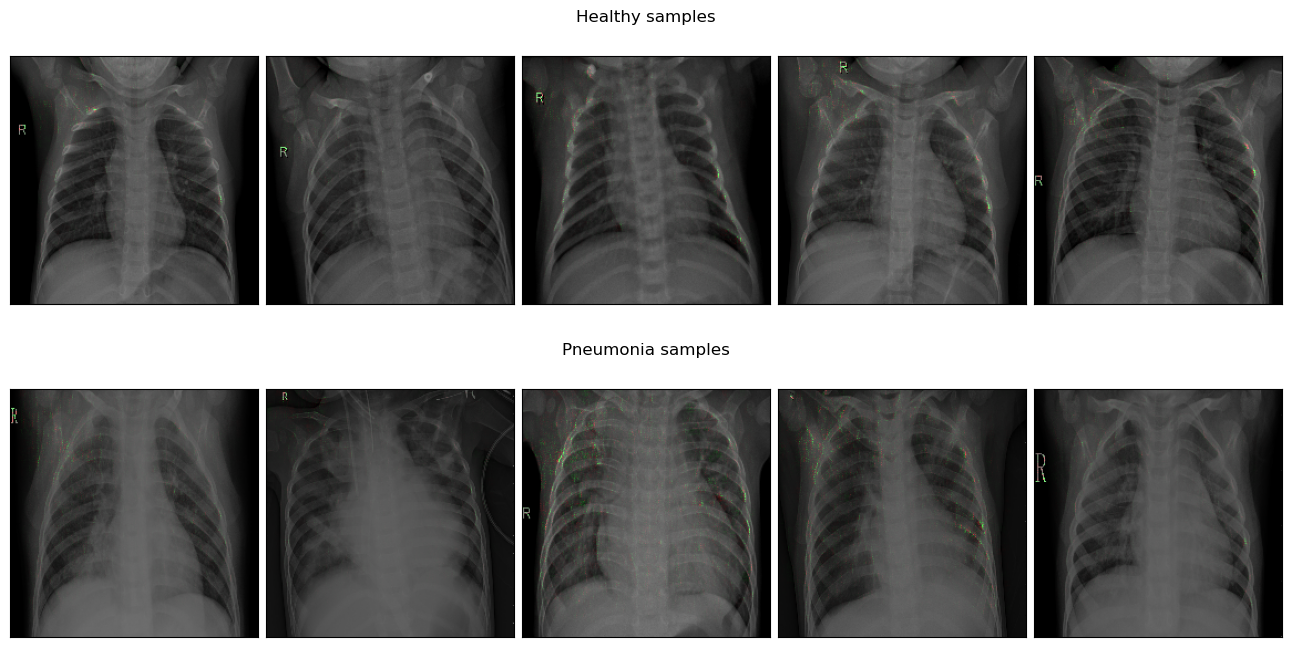

In [38]:
%%capture --no-display

fig = plt.figure(constrained_layout=True, figsize=[12.8, 6.6])
# fig.suptitle('Explaining outputs of model with integrated gradients')
subfigs = fig.subfigures(nrows=2, ncols=1)

offset = 20

subfigs[0].suptitle("Healthy samples")
axes = subfigs[0].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[i+offset][0].unsqueeze(0).requires_grad_(True)
    attribution = integrated_gradients(permuted_model, input, 500)
    ax.imshow(visualise_attribution_map(attribution, input, 1, 0.5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

subfigs[1].suptitle("Pneumonia samples")
axes = subfigs[1].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[-(i+offset+1)][0].unsqueeze(0).requires_grad_(True)
    attribution = integrated_gradients(permuted_model, input, 500)
    ax.imshow(visualise_attribution_map(attribution, input, 1, 0.5))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


### GradCAM attribution maps of the model trained on permuted data

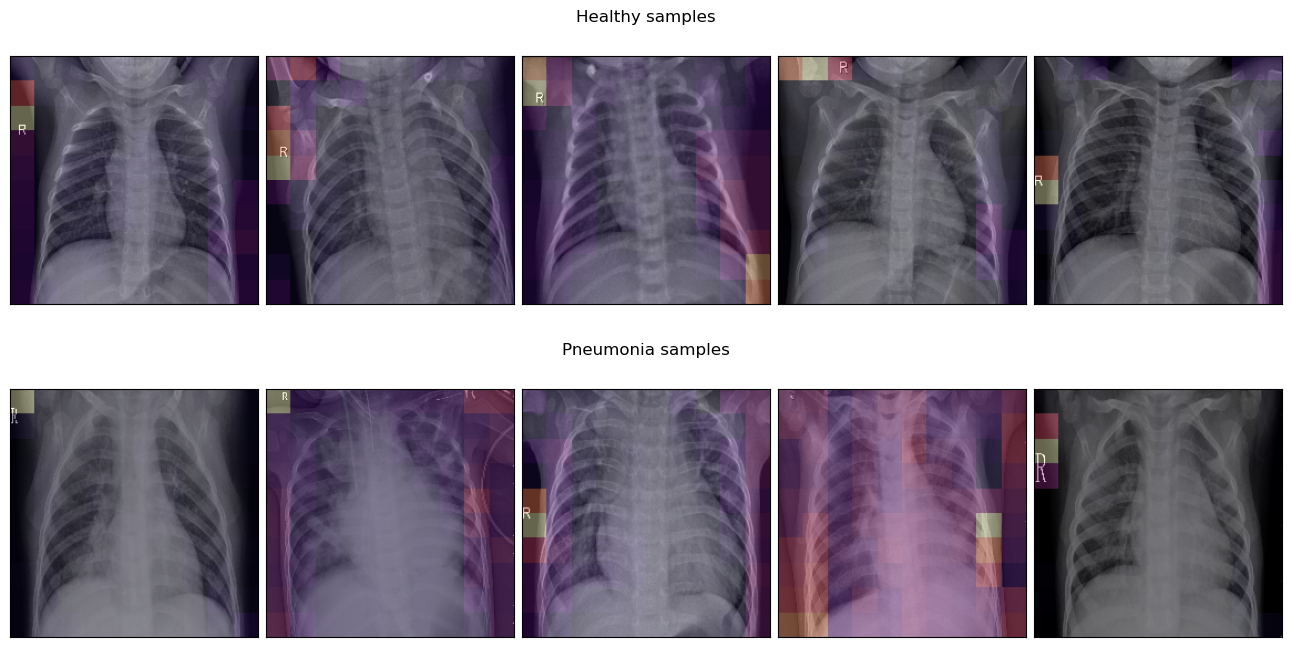

In [39]:
%%capture --no-display

fig = plt.figure(constrained_layout=True, figsize=[12.8, 6.6])
# fig.suptitle('Explaining outputs of model with GradCAM')
subfigs = fig.subfigures(nrows=2, ncols=1)

offset = 20

subfigs[0].suptitle("Healthy samples")
axes = subfigs[0].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[i+offset][0].unsqueeze(0).requires_grad_(True)
    attribution = gradCam(permuted_model, input)
    ax.imshow(visualise_gradCam(attribution, input))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

subfigs[1].suptitle("Pneumonia samples")
axes = subfigs[1].subplots(nrows=1, ncols=5)
for i, ax in enumerate(axes):
    input = train_dataset_orig[-(i+offset+1)][0].unsqueeze(0).requires_grad_(True)
    attribution = gradCam(permuted_model, input)
    ax.imshow(visualise_gradCam(attribution, input))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Interpretation

We see that both Integrated Gradients and GradCAM produce much different attribution maps for the model trained on data with randomly permuted labels in comparison to the attribution maps for the model trained on unpermuted data.

In the case of integrated gradients, the attribution maps of the model trained on permuted data only faintly highlight some edges present in the image, such as ribs, whereas in the unpermuted case, the model showed very clear positive attributions in the areas of high density and negative attributions in the corners of images.

In the case of GradCAM, in the permuted case, the attribution maps seem to assign a low importance to all regions of the image and a high importance to the area where the letter R is located. We presume that the model used the location of the letter R to essentially overfit on the training data and therefore assigns a high importance to it. This is in stark contrast to the unpermuted case where in healthy samples, almost no regions were highlighted and in diseased samples, only the regions with increased density were highlighted.

In a nutshell, both methods "pass" the randomization test since their outputs differ greatly depending on whether the labels were permuted or unpermuted.